In [ ]:
import cospar as cs
import pandas as pd
import scipy
import numpy as np
import os
import scanpy as sc
from cospar.plotting import _utils as pl_util

%reload_ext autoreload
%autoreload 2

import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
cs.settings.set_figure_params(format="png", figsize=[4, 3.5], dpi=100, fontsize=12, pointsize=3)

### CoSpar Basics

In [ ]:
adata = sc.read_h5ad('./datasets/CordBlood/adata_meta.h5ad')
adata

In [ ]:
adata.obs['meta_clones'] = adata.obs['Meta clones'].values
adata.obs['label_man'] = adata.obs['def_lab'].values
adata = adata[adata.obs['meta_clones'] != '-1.0', :]

In [ ]:
adata.obs['Clone_ID'] = [name[6:] for name in adata.obs.clones.values]

In [ ]:
adata.obs

In [ ]:
RNA_count_matrix = scipy.sparse.coo_matrix(np.expm1(adata.raw.X))

In [ ]:
adata_orig = cs.pp.initialize_adata_object(
    X_state=RNA_count_matrix,
    gene_names=adata.raw.var_names,
    cell_names=adata.obs.index,
    time_info=adata.obs.Timepoint.values,
    state_info=adata.obs.def_lab.values,
    X_emb=adata.obsm['X_umap'],
    X_pca=adata.obsm['X_pca'],
    data_des="cospar_cordblood",
)

In [ ]:
adata_orig

In [ ]:
cs.hf.update_time_ordering(adata_orig, updated_ordering=["Day3", "Day10", "Day17"])

In [ ]:
cs.pp.get_highly_variable_genes(adata_orig)
cs.pp.remove_cell_cycle_correlated_genes(adata_orig, corr_threshold=0.5, confirm_change=True)
cs.pp.get_X_clone(adata_orig, adata.obs.index.values, adata.obs.Clone_ID.values)

In [ ]:
cs.pl.clones_on_manifold(
    adata_orig,
    selected_clone_list=[1],
    color_list=["black", "red", "blue"],
    clone_markersize=8,
)

In [ ]:
selected_fates = ["Late Erythroid", "Monocyte", "DC", "Mast cell"]

Data saved at adata.uns['barcode_heatmap']


<Axes: title={'center': '516 clones'}>

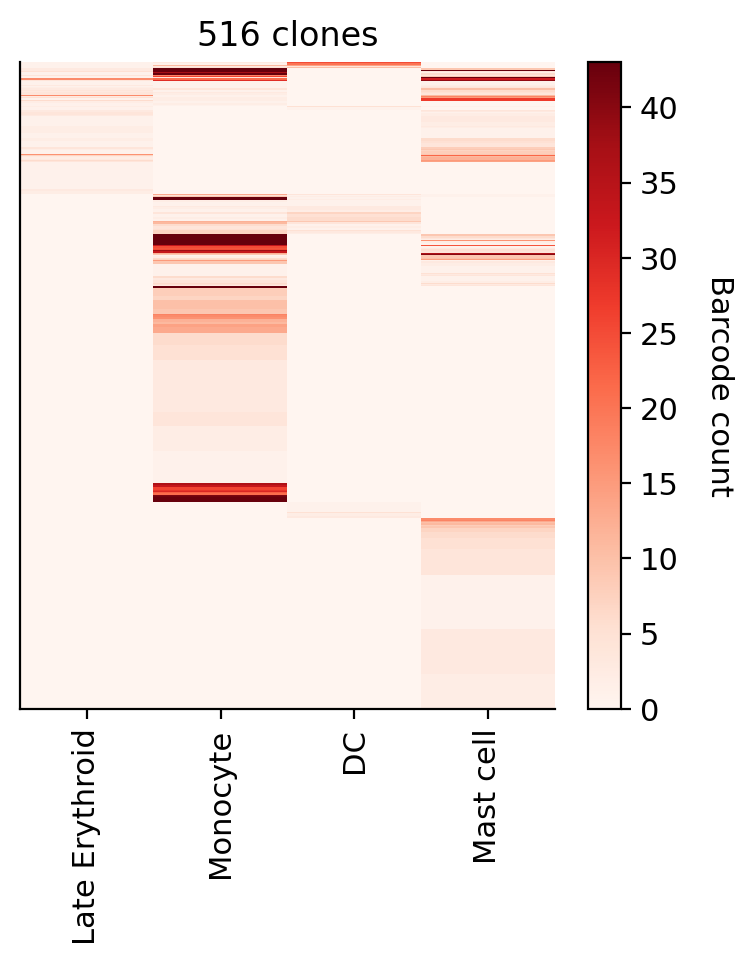

In [44]:
cs.pl.barcode_heatmap(
    adata_orig,
    selected_fates=selected_fates,
    color_bar=True,
    log_transform=False,
    fig_height=5,
    fig_width=4
)

In [ ]:
cs.pl.barcode_heatmap(
    adata_orig,
    selected_fates=selected_fates,
    color_bar=True,
    log_transform=False,
    binarize=True,
    fig_height=4
)

In [ ]:
cs.tl.fate_coupling(adata_orig, selected_fates=selected_fates, source="X_clone") 
cs.pl.fate_coupling(adata_orig, source="X_clone")

Strong coupling implies the existence of bi-potent or multi-potent cell states at the time of barcoding. You can visualize the fate hierarchy by a simple neighbor-joining method

In [ ]:
cs.tl.fate_hierarchy(adata_orig, selected_fates=selected_fates, source="X_clone")
cs.pl.fate_hierarchy(adata_orig, source="X_clone")

In [ ]:
sc.pl.umap(adata, color="def_lab", groups='DC')

In [ ]:
df_results = []

for fate in selected_fates:
    cs.tl.clonal_fate_bias(adata_orig, selected_fate=fate, alternative="two-sided")
    cs.pl.clonal_fate_bias(adata_orig)
    df_results.append(adata_orig.uns["clonal_fate_bias"])

In [ ]:
for idx, fate in enumerate(selected_fates):
    df_results[idx].to_csv(f'./data/fate_bias_cordblood_cospar_{fate}.csv')

### Transition Map Inference

In [ ]:
adata_all_latert = adata_orig.copy()
adata_all_latert = cs.tmap.infer_Tmap_from_multitime_clones(
    adata_all_latert,
    clonal_time_points=['Day3', 'Day10', 'Day17'],
    later_time_point='Day17',
    smooth_array=[20, 15, 10, 5],
    max_iter_N=10,
    compute_new=True
)

In [ ]:
adata_all_latert

### Transition Map Visualization

In [ ]:
cs.tl.fate_map(
    adata_all_latert,
    selected_fates=["Monocyte", "DC"],
    source="transition_map",
    map_backward=True,
)

cs.pl.fate_map(
    adata_all_latert,
    selected_fates=["Monocyte"],
    source="transition_map",
    plot_target_state=True,
    show_histogram=False,
)

In [ ]:
cs.tl.fate_potency(
    adata_all_latert,
    source="transition_map",
    map_backward=True,
    method="norm-sum",
    fate_count=True,
)

cs.pl.fate_potency(adata_all_latert, source="transition_map")

In [ ]:
cs.tl.fate_bias(
    adata_all_latert,
    selected_fates=["Monocyte", "DC"],
    source="transition_map",
    pseudo_count=0,
)

cs.pl.fate_bias(
    adata_all_latert,
    selected_fates=["Monocyte", "DC"],
    source="transition_map",
    plot_target_state=False,
)

In [ ]:
cs.pl.embedding(adata_all_latert, color=["fate_map_transition_map_Monocyte", "fate_map_transition_map_DC"])

In [ ]:
cs.tl.progenitor(
    adata_all_latert,
    selected_fates=["Monocyte", "DC"],
    source="transition_map",
    map_backward=True,
    bias_threshold_A=0.5,
    bias_threshold_B=0.5,
    sum_fate_prob_thresh=0.2,
    avoid_target_states=True,
)

cs.pl.embedding(adata_all_latert, color=['progenitor_transition_map_Monocyte', 'progenitor_transition_map_DC'])

In [ ]:
import numpy as np

cell_group_A = np.array(adata_all_latert.obs["diff_trajectory_transition_map_Monocyte"])
cell_group_B = np.array(adata_all_latert.obs["diff_trajectory_transition_map_DC"])

dge_gene_A, dge_gene_B = cs.tl.differential_genes(
    adata_all_latert, cell_group_A=cell_group_A, cell_group_B=cell_group_B, FDR_cutoff=0.05
)

In [ ]:
dge_gene_A

In [ ]:
selected_genes = dge_gene_A["gene"][:2]
cs.pl.gene_expression_on_manifold(
    adata_all_latert, selected_genes=selected_genes, color_bar=True, savefig=False
)

In [ ]:
gene_name_list = dge_gene_A['gene'].values[:20]
selected_fate = "Monocyte"

cs.pl.gene_expression_dynamics(
    adata_all_latert,
    selected_fate,
    gene_name_list,
    traj_threshold=0.2,
    invert_PseudoTime=False,
    compute_new=True,
    gene_exp_percentile=99,
    n_neighbors=15,
    plot_raw_data=False,
)

### Benchmark with Gillespie

#### Init Gillespie Results

In [ ]:
import os 
os.chdir('/ssd/users/mingzegao/clonaltrans/clonaltrans/')

path = '../trails/checkpoints/CordBloodDynamicRates/0322_185055/model_last.pt'
model = torch.load(path, map_location='cpu')
device = torch.device('cpu')

import os 
os.chdir('/ssd/users/mingzegao/clonaltrans/')

In [ ]:
anno = pd.read_csv(os.path.join(
    model.config['data_loader']['args']['data_dir'], 
    model.config['data_loader']['args']['annots']
))
cluster_names = anno['populations'].values[:model.N.shape[2]]

In [ ]:
gillespie_dir='./trails/checkpoints/CordBloodDynamicGillespie/0324_220241/models/'

#### Performance Comparison

In [ ]:
from clonaltrans.pl import with_cospar

In [ ]:
adata_all_latert.obs['meta_clones'] = adata.obs['meta_clones'].values

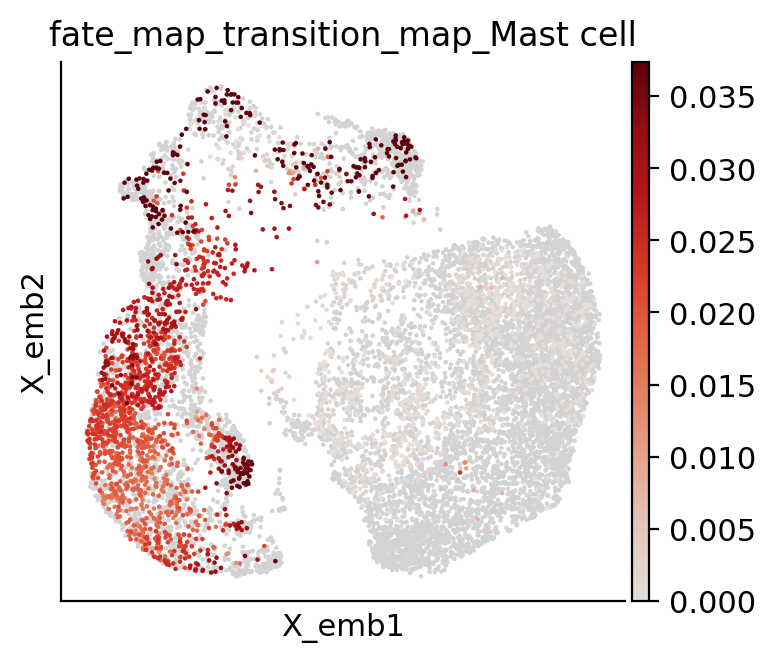

In [43]:
cs.pl.embedding(adata_all_latert, color=["fate_map_transition_map_Mast cell"], save='mast.svg')

In [ ]:
selected_fates = ["Late Erythroid", "Monocyte", "DC", "Mast cell"]

In [ ]:
from clonaltrans.pl import with_cospar_all
with_cospar_all(
    adata_all_latert, 
    adata, 
    model, 
    cluster_names,
    gillespie_dir,
    selected_fates,
    save='benchmarkfate'
)

In [ ]:
from clonaltrans.pl import with_cospar_all
with_cospar_all(
    adata_all_latert, 
    adata, 
    model, 
    cluster_names,
    gillespie_dir,
    selected_fates,
    show_fate=False,
    save='benchmarkprog'
)

In [ ]:
with_cospar(
    adata_all_latert, 
    adata, 
    'HSC_MPP', 
    'Late Erythroid', 
    model, 
    cluster_names,
    gillespie_dir,
    save='benchexamp'
)

In [ ]:
with_cospar(
    adata_all_latert, 
    adata, 
    'HSC_MPP', 
    'Monocyte', 
    model, 
    cluster_names,
    gillespie_dir
)

In [ ]:
with_cospar(
    adata_all_latert, 
    adata, 
    'NMP', 
    'Monocyte', 
    model, 
    cluster_names,
    gillespie_dir
)

In [ ]:
with_cospar(
    adata_all_latert, 
    adata, 
    'MEMP', 
    'Late Erythroid', 
    model, 
    cluster_names,
    gillespie_dir
)